# Multiclass classification with deep neural networks
This is deep neural network implementation from scratch, without using any machine learning libraries.

The dataset used is MNIST dataset of handwritten images.

## Table of Contents
- [1 - Load data](#1)
- [2 - Initialize Parameters](#2)
- [3 - Cost Function](#3)
- [4 - Activation Function](#4)
- [5 - Forward Propagation](#5)
- [6 - Backward Propagation](#6)
- [7 - Update Parameters](#7)
- [8 - Train Model](#8)
- [9 - Save and Load Model](#9)
- [10 - Predict](#10)
- [11 - Print Images](#11)

In [26]:
# import sys
# !{sys.executable} -m pip install python-mnist

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
import csv
import numpy as np

np.random.seed(0)

<a name='1'></a>
### Load data
Dataset contains training and test sets.
Each example is flattened `28x28` greyscale image of with shape `784 (28 * 28)`.

By default label set is a vector that contains single digit from `0` to `9`. 
In order to make it work first we need to expand this into a 10 dimensional matrix
e.g if the label is `4` we expand it to be `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`
After this the label set shape will become `10 x 60000`

In [28]:
data1 = np.loadtxt('SP/tren_data1___09.txt')
data1 = np.random.permutation(data1)
data1_dict = {"train": data1[:int(len(data1)*0.8)], "test": data1[int(len(data1)*0.8):]}
x_train = data1_dict['train'][:,:-1].T
y_train_raw = data1_dict['train'][:,-1]
x_test = data1_dict['test'][:,:-1].T
y_test = data1_dict['test'][:,-1]
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer() # one hot encoding
# 
# Y_train = lb.fit_transform(y_train)
# Y_train = Y_train.T
# Y_test = lb.fit_transform(y_test)
# Y_test = Y_test.T


m_train = x_train.shape[1] # Number of examples
num_px = x_train.shape[0] # Number of input elements
m_test = x_test.shape[1] # Number of test examples

# Expand Y values to vectors
# e.g. 4 will become [0, 0, 0, 1]
y_train = lb.fit_transform(y_train_raw)
y_train = y_train.T
y_test = y_test.reshape(1, y_test.shape[0])
print ('Number of training examples: ', m_train)
print ('Number of testing examples:  ', m_test)
print ('------')
print ('Flattened image size:        ', num_px)
print ('------')
print ('x_train shape:               ', x_train.shape)
print ('y_train shape initial:       ', y_train_raw.shape)
print ('------')
print ('y_train shape expanded:      ', y_train.shape)
print ('------')
print ('x_test shape:                ', x_test.shape)
print ('y_test shape:                ', y_test.shape)

Number of training examples:  400
Number of testing examples:   100
------
Flattened image size:         2
------
x_train shape:                (2, 400)
y_train shape initial:        (400,)
------
y_train shape expanded:       (5, 400)
------
x_test shape:                 (2, 100)
y_test shape:                 (1, 100)


In [29]:
print(y_test)

[[2. 4. 2. 5. 5. 3. 4. 3. 1. 2. 5. 5. 5. 5. 4. 1. 1. 3. 2. 4. 3. 1. 4. 3.
  4. 5. 1. 2. 4. 5. 3. 5. 1. 4. 1. 5. 5. 2. 3. 1. 2. 4. 2. 2. 3. 3. 1. 1.
  2. 2. 5. 5. 3. 5. 4. 5. 2. 3. 5. 2. 1. 4. 5. 5. 4. 2. 3. 5. 2. 5. 3. 1.
  4. 1. 2. 4. 5. 2. 5. 1. 2. 4. 4. 1. 5. 1. 1. 3. 3. 3. 3. 1. 4. 2. 3. 4.
  2. 2. 1. 2.]]


## Functions 

<a name='2'></a>
### Initialize Parameters

In [30]:
def initialize_parameters(dims):
    """
    Initializes parameters
        Wl -- to random values
        bl -- to zeros
        
    Arguments:
        dims -- list of layer sizes
    
    Returns:
        parameters
            Wl -- weights matrix, shape (current layer nodes, previous layer nodes)
            bl -- biases vector, shape (current layer nodes, 1)
    """
    np.random.seed(1)
    parameters = {}
    L = len(dims) # Number of layers

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(dims[l], dims[l-1]) / np.sqrt(dims[l-1])
        parameters['b' + str(l)] = np.zeros((dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (dims[l], dims[l-1]))
        assert(parameters['b' + str(l)].shape == (dims[l], 1))
        
    return parameters

<a name='3'></a>
## Cost Function

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{1}$$


In [31]:
def compute_cost(AL, Y):
    """
    Computes the cost

    Arguments:
        AL -- output vector(predictions), shape (number of classes, number of examples)
        Y -- actual values matrix, shape (number of classes, number of examples)

    Returns:
        cost -- cross-entropy cost
    """
    
    m = Y.shape[1] # number of examples  
    n = Y.shape[0] # number of classes
    cost = np.zeros((n, 1)) + 1
    
    for i in range(n):
        al = AL[i, :]
        y = Y[i, :]
        # cost[i, :] = (1./m) * (-np.dot(y, np.log(al).T) - np.dot(1-y, np.log(1-al).T))
        # 1/2*(y-al)^2
        cost[i, :] = (1./(2*m)) * np.sum(np.square(y-al))
    
#     cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) 
#     cost = np.squeeze(cost)    

    
    return cost

<a name='4'></a>
### Activation Function

In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$.



- **ReLU**: $A = RELU(Z) = max(0, Z)$. 


- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit.

- **`relu_backward`**: Implements the backward propagation for RELU unit.

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{2}$$  


In [32]:
def sigmoid(Z):
    """
    Calculates sigmoid of any input
    
    Arguments:
        Z -- numpy array of any shape
    
    Returns:
        A -- sigmoid of input Z, shape (same as Z)
        cache -- returns Z for caching, useful in backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Calculates RELU.

    Arguments:
        Z -- numpy array of any shape

    Returns:
        A -- Activation of Z
        cache -- returns Z for caching, useful in backpropagation
    """
    
    A = np.maximum(0,Z)
    
    assert A.shape == Z.shape, 'A should be same shape as Z'
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Calculates the backward propagation for a single RELU unit.

    Arguments:
        dA -- post-activation gradient, of any shape
        cache -- returns Z for caching, useful in backpropagation

    Returns:
        dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # convert dz to a numpy array.
    
    # When z <= 0, set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert dZ.shape == Z.shape, 'dZ should be the same shape as Z'
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Calculates the backward propagation for a single SIGMOID unit.

    Arguments:
        dA -- post-activation gradient, of any shape
        cache -- returns Z for caching, useful in backpropagation

    Returns:
        dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert dZ.shape == Z.shape, 'dZ should be the same shape as Z'
    
    return dZ

<a name='5'></a>
## Forward Propagation
Calculate forward propagation:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{3}$$
Followed by an activation.



In [33]:
def forward_pass(A_prev, W, b, activation):
    """
    Calculates activations of Z and passes to the next layer.
    
    Arguments:
        A_prev -- activations of previous layer
        W -- weight matrix of the current layer
        b -- bias values of the current layer
        activation -- type of activation function
    """
    activation = activation.lower()
    assert activation == 'relu' or activation == 'sigmoid', "activation should be either 'relu', or 'sigmoid'"
    
    Z = W.dot(A_prev) + b
    assert Z.shape == (W.shape[0], A_prev.shape[1]), 'wrong Z shape'

    linear_cache = (A_prev, W, b)   
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert A.shape == (W.shape[0], A_prev.shape[1]), 'wrong A shape'
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [34]:
def forward_propagate(X, parameters):
    """
    Propagates forward.
    
    Arguments:
        X -- numpy array of input data, shape (number of examples, input size)
        parameters -- initialized parameters
    
    Returns:
        AL -- output layer of predictions
        caches -- list of caches containing:
                    cache of relu activations
                    cache of sigmoid activation of output layer
    """

    caches = []
    A = X
    L = len(parameters) // 2 # number of layers
    
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_pass(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)        
    
    AL, cache = forward_pass(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert AL.shape == (dims[len(dims) - 1],X.shape[1]), 'wrong output layer shape'

    return AL, caches

<a name='6'></a>
### Backward Propagation

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{4}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{5}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{6}$$

Pass parameters back by one layer

In [35]:
def backward_pass(dA, cache, activation):
    """
    Calculates derivative of activations and passes to the previous layer.
    
    Arguments:
        dA -- post-activation gradient of the current layer
        cache -- tuple of caches (linear_cache, activation_cache), saved during forward propagation
        activation -- name of activation function
    
    Returns:
        dA_prev -- Gradient of the cost with respect to the activation of the previous layer, same shape as A_prev
        dW -- Gradient of the cost with respect to W, same shape as W
        db -- Gradient of the cost with respect to b, same shape as b
    """
    linear_cache, activation_cache = cache
        
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]    
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

Backward propagate through all the layers

In [36]:
def backward_propagate(AL, Y, caches):
    """
    Propagates backwards
    
    Arguments:
        AL -- output layer predictions
        Y -- actual values
        caches -- list of caches containing:
                    cache of relu activations
                    cache of sigmoid activations of the last layer
    
    Returns:
        grads -- A dictionary of gradients 'dA', 'dW', 'db'

    """
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1] # number of examples
    Y = Y.reshape(AL.shape)
    
    # Initialize the backpropagation
    # dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # loss derivative, loss = 1/2m*(y-al)^2
    dAL = -(Y - AL)
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_pass(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_pass(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

<a name='7'></a>
### Update Parameters

Update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{8}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{9}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, store them in the parameters dictionary. 

In [37]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters.
    
    Arguments:
        parameters -- dictionary of parameters 
        grads -- dictionary of gradients
    
    Returns:
        parameters -- dictionary of updated parameters 'W' and 'b'
    """
    
    L = len(parameters) // 2 # number of layers

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

<a name='8'></a>
### Train Model

User above defined functions to train a model

In [38]:
def model(X, Y, dims, learning_rate = 0.01, epochs = 100, print_cost=False):
    """
    Trains full deep neural network.
    
    Arguments:
        X -- numpy array of input data, shape (flattened image pixel number, number of examples)
        Y -- actual values
        layers_dims -- list of layers
        learning_rate -- learning rate
        epochs -- number of iterations
        print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
        parameters -- learned parameters.
    """

    costs = []

    parameters = initialize_parameters(dims)
        
    # Gradient descent
    for i in range(0, epochs):

        AL, caches = forward_propagate(X, parameters)
        
        cost = compute_cost(AL, Y)

        grads = backward_propagate(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == epochs - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == epochs:
            costs.append(cost)
    
    return parameters, costs

In [39]:
input_layer = x_train.shape[0] # set input layer size
dims = [input_layer, 10, 5] # set layer number and sizes

# parameters, costs = model(x_train[:, :10000], y_train[:, :10000], dims, learning_rate=0.0075, epochs = 100, print_cost = True)
parameters, costs = model(x_train, y_train, dims, learning_rate=0.095, epochs = 2000, print_cost = True)

Cost after iteration 0: [0.2209198  0.1027425  0.23474041 0.26078658 0.26229972]
Cost after iteration 100: [0.04477774 0.04119648 0.0160158  0.00638025 0.00419065]
Cost after iteration 200: [0.03793133 0.03333435 0.00853425 0.00309547 0.00146336]
Cost after iteration 300: [0.03170153 0.02702746 0.00653326 0.00268548 0.00152255]
Cost after iteration 400: [0.02642278 0.02264216 0.00527748 0.00239392 0.00154124]
Cost after iteration 500: [0.02204136 0.01935886 0.00437902 0.00213274 0.00145885]
Cost after iteration 600: [0.0183519  0.01698771 0.00364767 0.00189129 0.0013406 ]
Cost after iteration 700: [0.01491156 0.01555913 0.0029844  0.00165854 0.00120174]
Cost after iteration 800: [0.01214498 0.01440504 0.00245686 0.00143818 0.00105567]
Cost after iteration 900: [0.01009485 0.01327673 0.00206836 0.00125142 0.00092864]
Cost after iteration 1000: [0.00852688 0.0122228  0.00177796 0.00109889 0.00082401]
Cost after iteration 1100: [0.0073009  0.01126097 0.00155685 0.00097382 0.00073771]
Cost

<a name='9'></a>
## Save and Load Model

Save model to csv files for later use

In [40]:
def save_model(parameters):
    path = './model/'
    f = open(path + 'param_keys.csv', 'w')
    w = csv.writer(f, delimiter=',')
    keys = list(parameters.keys())
    w.writerow(keys)
    f.close()
    
    for key in keys:        
        np.savetxt(path + key + '.csv', parameters[key], delimiter=",")        
        
def load_model():
    path = './model/'
    parameters = {}
    param_keys = []
    with open(path + 'param_keys.csv', newline='') as csvfile:
        content = csv.reader(csvfile, delimiter=',', quotechar='|')            
        for row in content:
            if len(row):
                param_keys = list(row)
    for key in param_keys:
        p = np.genfromtxt(path + key + '.csv', delimiter=',')
        parameters[key] = p.reshape(p.shape[0], -1)
    return parameters

In [41]:
# save_model(parameters)
# parameters = load_model()
# print(parameters)

<a name='10'></a>
## Predict

Use forward propagation to make predictions

In [42]:
def predict(X, y, parameters):
    """
    Predicts using learned parameters.
    
    Arguments:
        X -- input data
        parameters -- parameters of the prevously trained model
        
    Returns:
        right_preds -- dictionary of the right predictions
        wrong_preds -- dictionary of the wrong predictions
        low_confidence_preds -- dictionary of the predictions with low confidence
    """
    
    m = X.shape[1] # number of examples
    sum_rights = 0 # number of correct predictions
    
    predictions = {
        "right": {},
        "wrong": {},
        "low_confidence": {}
    }

    # Forward propagation
    preds, caches = forward_propagate(X, parameters)
    y_pred = []

    for i in range(preds.shape[1]):
        max_pred = preds[:, i]
        prediction = np.argmax(max_pred, axis=None)
        actual = y[:, i].squeeze()
        y_pred.append(prediction+1)
        
        if max(max_pred) < 0.1: 
            predictions['low_confidence'][i] = {
                'pred': prediction+1,
                'actual': int(actual),
                'confidence': preds[prediction, i]
            }
        elif prediction+1 == actual:
            sum_rights += 1
            predictions['right'][i] = {
                'pred': prediction+1,
                'actual': int(actual),
                'confidence': preds[prediction, i]
            }
        else:
            predictions['wrong'][i] = {
                'pred': prediction+1,
                'actual': int(actual),
                'confidence': preds[prediction, i]
            }

    accuracy = sum_rights/m
    
    return accuracy, predictions, y_pred

In [43]:
accuracy, predictions, y_pred = predict(x_test, y_test, parameters)
print('accuracy:       ', accuracy)
print('correct:        ', len(predictions['right']))
print('mistakes:       ', len(predictions['wrong']))
print('low confidence: ', len(predictions['low_confidence']))

accuracy:        1.0
correct:         100
mistakes:        0
low confidence:  0


In [44]:
print(y_pred)

[2, 4, 2, 5, 5, 3, 4, 3, 1, 2, 5, 5, 5, 5, 4, 1, 1, 3, 2, 4, 3, 1, 4, 3, 4, 5, 1, 2, 4, 5, 3, 5, 1, 4, 1, 5, 5, 2, 3, 1, 2, 4, 2, 2, 3, 3, 1, 1, 2, 2, 5, 5, 3, 5, 4, 5, 2, 3, 5, 2, 1, 4, 5, 5, 4, 2, 3, 5, 2, 5, 3, 1, 4, 1, 2, 4, 5, 2, 5, 1, 2, 4, 4, 1, 5, 1, 1, 3, 3, 3, 3, 1, 4, 2, 3, 4, 2, 2, 1, 2]


(2, 100)
(1, 100)
(2, 58080)
(1, 58080)


Text(0, 0.5, 'petal length')

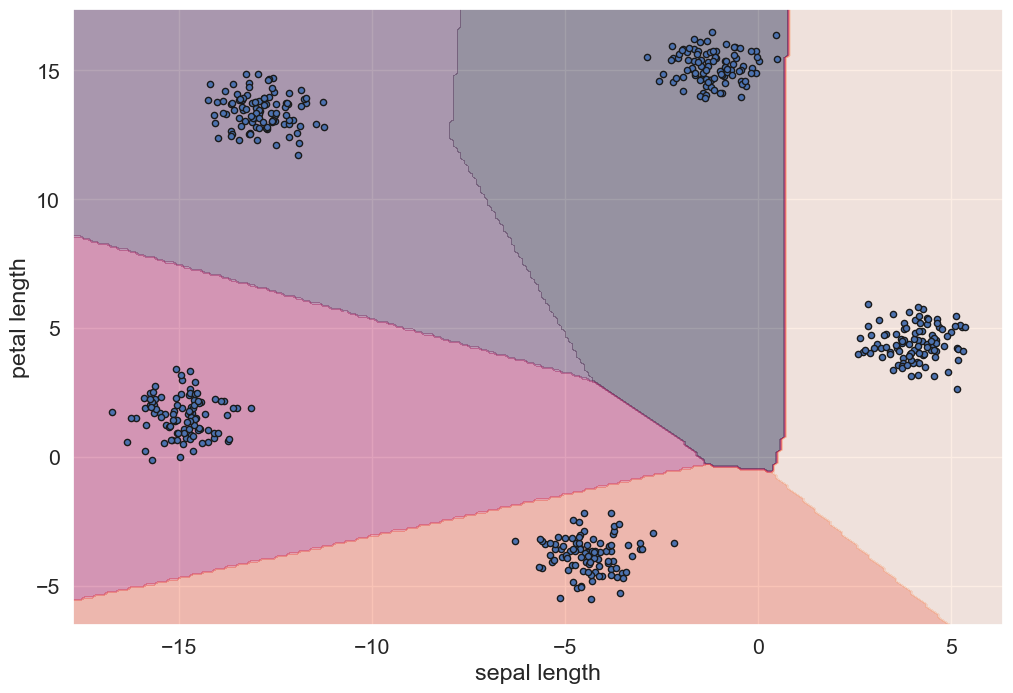

In [45]:
accuracy, predictions, y_pred = predict(x_test, y_test, parameters)
print(x_test.shape)
print(y_test.shape)
%matplotlib inline
dt = data1[:,:-1]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
inp = np.c_[xx.ravel(), yy.ravel()].T
print(inp.shape)
print(np.zeros((1, inp.shape[1])).shape)
_, _, Z = predict(inp, np.zeros((1, inp.shape[1])), parameters)

# Put the result into a color plot
Z = np.array(Z)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1],s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

<hr>

#### Print predictions

In [46]:
data1 = np.loadtxt('SP/tren_data2___09.txt')
data1 = np.random.permutation(data1)
data1_dict = {"train": data1[:int(len(data1)*0.8)], "test": data1[int(len(data1)*0.8):]}
x_train = data1_dict['train'][:,:-1].T
y_train_raw = data1_dict['train'][:,-1]
x_test = data1_dict['test'][:,:-1].T
y_test = data1_dict['test'][:,-1]
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer() # one hot encoding
# 
# Y_train = lb.fit_transform(y_train)
# Y_train = Y_train.T
# Y_test = lb.fit_transform(y_test)
# Y_test = Y_test.T


m_train = x_train.shape[1] # Number of examples
num_px = x_train.shape[0] # Number of input elements
m_test = x_test.shape[1] # Number of test examples

# Expand Y values to vectors
# e.g. 4 will become [0, 0, 0, 1]
y_train = lb.fit_transform(y_train_raw)
y_train = y_train.T
y_test = y_test.reshape(1, y_test.shape[0])
print ('Number of training examples: ', m_train)
print ('Number of testing examples:  ', m_test)
print ('------')
print ('Flattened image size:        ', num_px)
print ('------')
print ('x_train shape:               ', x_train.shape)
print ('y_train shape initial:       ', y_train_raw.shape)
print ('------')
print ('y_train shape expanded:      ', y_train.shape)
print ('------')
print ('x_test shape:                ', x_test.shape)
print ('y_test shape:                ', y_test.shape)

Number of training examples:  400
Number of testing examples:   100
------
Flattened image size:         2
------
x_train shape:                (2, 400)
y_train shape initial:        (400,)
------
y_train shape expanded:       (5, 400)
------
x_test shape:                 (2, 100)
y_test shape:                 (1, 100)


In [47]:
input_layer = x_train.shape[0] # set input layer size
dims = [input_layer, 6,8, 5] # set layer number and sizes

# parameters, costs = model(x_train[:, :10000], y_train[:, :10000], dims, learning_rate=0.0075, epochs = 100, print_cost = True)
parameters, costs = model(x_train, y_train, dims, learning_rate=0.075, epochs = 2000, print_cost = True)

Cost after iteration 0: [0.28903734 0.05988741 0.2273113  0.1875259  0.1444003 ]
Cost after iteration 100: [0.04290441 0.04263345 0.05724692 0.04352684 0.03892331]
Cost after iteration 200: [0.02204433 0.02773161 0.03257213 0.0230633  0.01827429]
Cost after iteration 300: [0.01662596 0.02395766 0.0232113  0.01771078 0.01449153]
Cost after iteration 400: [0.01344517 0.01963188 0.01933624 0.01580287 0.01202994]
Cost after iteration 500: [0.01134148 0.01633681 0.01654755 0.01455795 0.01024222]
Cost after iteration 600: [0.00981954 0.01381072 0.01428209 0.01355813 0.00887537]
Cost after iteration 700: [0.00863358 0.01188321 0.01240004 0.01265693 0.00779803]
Cost after iteration 800: [0.00770085 0.01044109 0.0108758  0.01178707 0.00693686]
Cost after iteration 900: [0.00699718 0.00911146 0.00966258 0.01098042 0.00625278]
Cost after iteration 1000: [0.00639457 0.0082407  0.00866368 0.01016332 0.00566122]
Cost after iteration 1100: [0.00586281 0.00766211 0.00784115 0.00939212 0.00516371]
Cost

Text(0, 0.5, 'petal length')

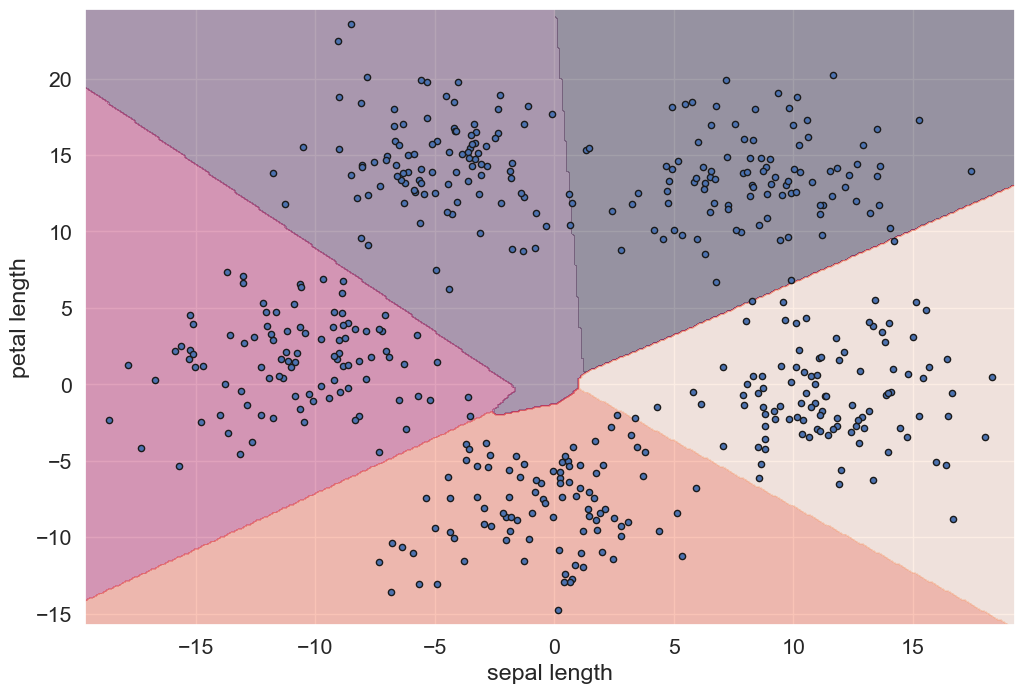

In [48]:
accuracy, predictions, y_pred = predict(x_test, y_test, parameters)
%matplotlib inline
dt = data1[:,:-1]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
inp = np.c_[xx.ravel(), yy.ravel()].T
_, _, Z = predict(inp, np.zeros((1, inp.shape[1])), parameters)

# Put the result into a color plot
Z = np.array(Z)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1],s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

In [49]:
accuracy, predictions, y_pred = predict(x_train, y_train_raw.reshape(1, y_train_raw.shape[0]), parameters)
print('accuracy:       ', accuracy)
accuracy, predictions, y_pred = predict(x_test, y_test, parameters)
print('accuracy:       ', accuracy)

accuracy:        0.9725
accuracy:        0.99


[[25  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 16  0  0]
 [ 0  0  0 21  1]
 [ 0  0  0  0 15]]


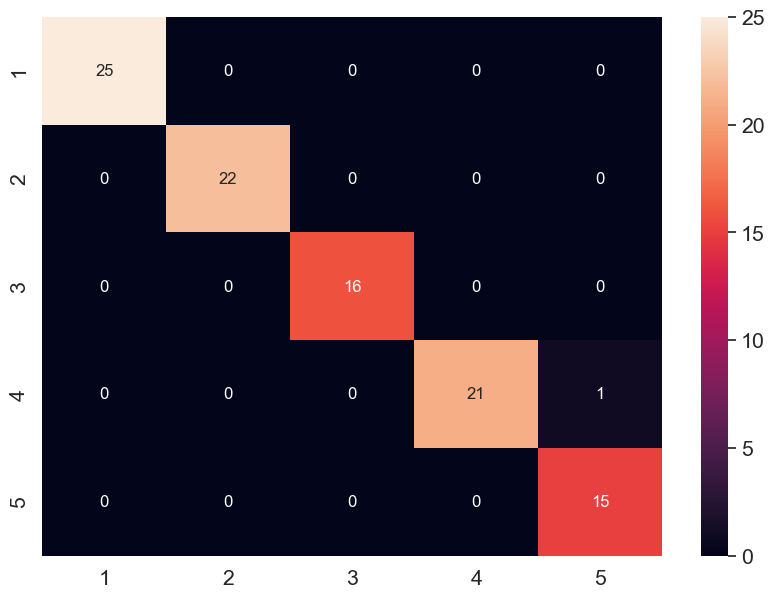

In [50]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test[0], y_pred)
print(cm)
# plot confusion matrix
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, range(1,6), range(1,6))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
